This notebook is an example of a `PreFab` prediction of a simple structure: a square to be fabricated on a SOI e-beam process. This example demonstrates:
1. Initializing a Predictor
2. Preparing a device image for prediction
3. Running a prediction
4. Analyzing a prediction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import prefab as pf

Nothing has to be done here. Models are named by specifying the type ('p' for predictor), the fab facility and process name, and the version of the model.

In [2]:
MODEL_TYPE = 'p'
MODEL_NAME = 'ANT_NanoSOI'
MODEL_VERSION = 'v3'

predictor = pf.Predictor(model_type=MODEL_TYPE, model_name=MODEL_NAME,
                         model_version=MODEL_VERSION)

Second, we load a device image in as a numpy matrix with pixel values of 0 or 1. A square shape is used here, but you can try the other devices in the `devices/` folder, or add your own!

Because an image may not be in the required scale (1 nm/px), we must specify the length of the device loaded in (in nm) to prepare it for prediction.

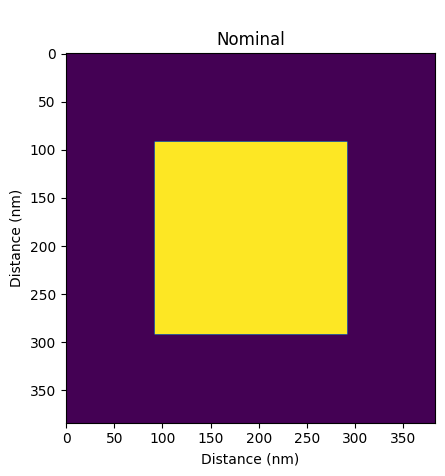

In [3]:
DEVICE_LENGTH = 200
device = pf.load_device_img(path='../devices/rectangle_128x128_256x256.png',
                            device_length=DEVICE_LENGTH)

plt.imshow(device)
plt.title('\nNominal')
plt.ylabel('Distance (nm)')
plt.xlabel('Distance (nm)')
plt.show()

Third, we're ready to make the prediction. We must specify the step length, which determines how fine the prediction is. A small step length will produce nice predictions, but may require significant memory resources for large devices. For this small square, we can use a fine step length.

We should also specify if we want a binarized output. By default, the predictor outputs the raw prediction, which shows the "fuzzy" areas of the structure that will vary from fab to fab, device to device. If we choose to binarize, the predictor will output the most likely outcome. We can also binarize after the prediction so we have both to view.

**A note about performance**. Your first prediction will be relatively slow, as the cloud server must do a cold start and load the necessary model(s). After the first prediction, the server will be "hot" for some time and the subsequent predictions will be much quicker.

In [4]:
STEP_LENGTH = 8
prediction = predictor.predict(device=device, step_length=STEP_LENGTH,
                               binary=False)

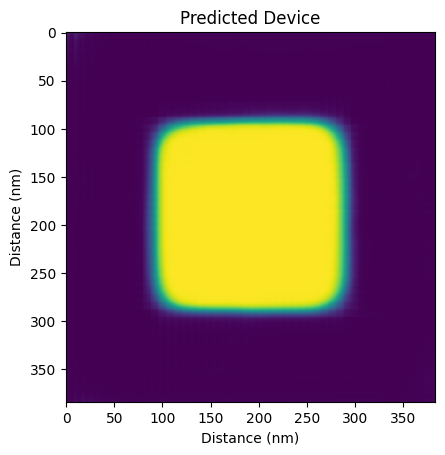

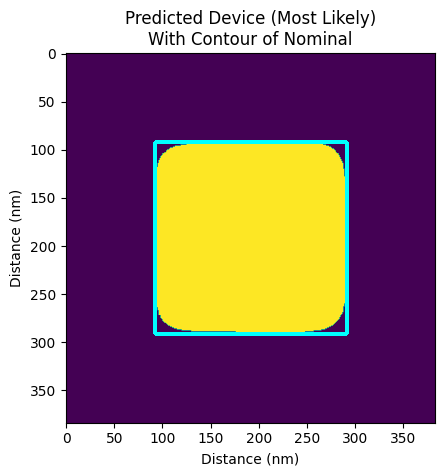

In [5]:
plt.imshow(prediction)
plt.title('Predicted Device')
plt.ylabel('Distance (nm)')
plt.xlabel('Distance (nm)')
plt.show()

plt.imshow(pf.binarize(prediction))
plt.imshow(pf.get_contour(device=device), cmap='cool')
plt.title('Predicted Device (Most Likely)\nWith Contour of Nominal')
plt.ylabel('Distance (nm)')
plt.xlabel('Distance (nm)')
plt.show()

Lastly, let's do some analysis of the prediction we just made. The first analysis we'll do is to plot the possible variations between the nominal device and the prediction. From this plot, we see that the corners of the square are highly likely to be rounded, with some degree of uncertainty as to where exactly the edges will be (no process is perfect!).

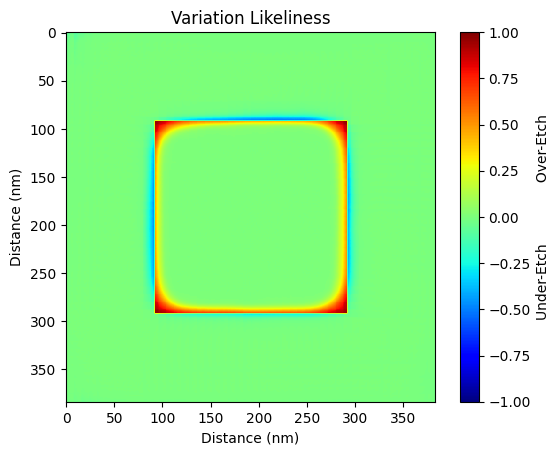

In [6]:
variation = device - prediction

plt.imshow(variation, cmap='jet', vmin=-1, vmax=1)
plt.title('Variation Likeliness')
plt.ylabel('Distance (nm)')
plt.xlabel('Distance (nm)')
cb = plt.colorbar()
cb.set_label('Under-Etch              Over-Etch')
plt.show()

Let's do a very simple calculation of how many pixels (nm<sup>2</sup>) are predicted to be preserved.

In [7]:
overlap = np.count_nonzero(pf.binarize(prediction))/np.count_nonzero(device)
print(f'Prediction is {100*overlap:.1f}% Preserved')

Prediction is 95.2% Preserved


Another way we can represent these results is to highlight where the edge is most likely to be (i.e., where the predictor is most uncertain on if the pixel is silicon or silica). The bright line of this plot is where the edge is most likely to be, but in reality, there is a range of possible locations. For finer features (i.e., the corners of this square), we see that uncertainty is increased and the range of possible edge positions is larger! This is a sign that we want to avoid using these types of features for our device if possible.

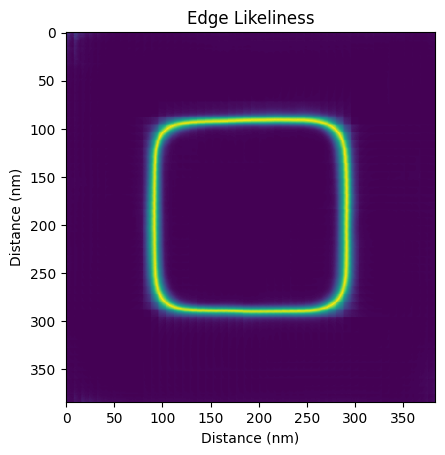

In [8]:
uncertainty = pf.get_uncertainty(prediction)

plt.imshow(uncertainty)
plt.title('Edge Likeliness')
plt.ylabel('Distance (nm)')
plt.xlabel('Distance (nm)')
plt.show()

And that's it!